# EAD Model

In [1]:
%load_ext autoreload
%autoreload 2

## Change to project directory (google colab)

In [2]:
import os
os.chdir('/content/drive/MyDrive/projects/credit-risk-modelling-udemy/notebooks')
os.listdir('../')

['venv-hpx360-win',
 'data',
 'src',
 '.git',
 'requirements.txt',
 'README.md',
 'src.egg-info',
 'setup.py',
 'reports',
 'outputs',
 'notebooks',
 '.gitignore']

In [4]:
!pip install -e ../.

Obtaining file:///content/drive/MyDrive/projects/credit-risk-modelling-udemy
  Running setup.py develop for src


## Some imports

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import src
from src.project.config import PROJECT_DIR

## Stage 2 - Linear Regression

* In Stage 1, we predicted whether the recovery rate for loan defaults will be 0 or greater than 0.
* In Stage 2, we will use Linear Regression to model the recovery rate, if the recovery rate is indeed greater than 0.

## Load Data

In [4]:
fpath = os.path.join(PROJECT_DIR, 'outputs', 'loan_data_2007_2014_defaults_for_lgd_ead_nb8.pkl')
loan_data_defaults = pd.read_pickle(fpath)

In [5]:
lgd_stage_2_data = loan_data_defaults[loan_data_defaults['recovery_rate_0_1'] == 1].reset_index(drop=True)

## Variable List

In [14]:
variable_lst = ['grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:MORTGAGE',
'home_ownership:NONE',
'home_ownership:OTHER',
'home_ownership:OWN',
'home_ownership:RENT',
'verification_status:Not Verified',
'verification_status:Source Verified',
'verification_status:Verified',
'purpose:car',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:educational',
'purpose:home_improvement',
'purpose:house',
'purpose:major_purchase',
'purpose:medical',
'purpose:moving',
'purpose:other',
'purpose:renewable_energy',
'purpose:small_business',
'purpose:vacation',
'purpose:wedding',
'initial_list_status:f',
'initial_list_status:w',
'term_int',
'emp_length_int',
'mths_since_issue_d',
'mths_since_earliest_cr_line',
'funded_amnt',
'int_rate',
'installment',
'annual_inc',
'dti',
'delinq_2yrs',
'inq_last_6mths',
'mths_since_last_delinq',
'mths_since_last_record',
'open_acc',
'pub_rec',
'total_acc',
'acc_now_delinq',
'total_rev_hi_lim']


variable_ref_cat =  ['grade:G',
'home_ownership:RENT',
'verification_status:Verified',
'purpose:credit_card',
'initial_list_status:f']

## Splitting Data

In [7]:
DEP_VARS = ['good_bad_loan', 'recovery_rate', 'recovery_rate_0_1', 'ccf']
RANDOM_STATE = 42

In [27]:
from sklearn.model_selection import train_test_split
lgd_inputs_stage_2_train, lgd_inputs_stage_2_test, lgd_targets_stage_2_train, lgd_targets_stage_2_test = train_test_split(lgd_stage_2_data.drop(DEP_VARS, axis=1), lgd_stage_2_data['recovery_rate'],
                                                                                                                         test_size=0.2, random_state=RANDOM_STATE)



## Preparing the Inputs

In [28]:
lgd_inputs_stage_2_train = lgd_inputs_stage_2_train[variable_lst].drop(variable_ref_cat, axis=1).astype(float)
lgd_inputs_stage_2_test = lgd_inputs_stage_2_test[variable_lst].drop(variable_ref_cat, axis=1).astype(float)


## Modelling recovery_rate

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import scipy

In [46]:
class LinearRegressionWithPValues(LinearRegression):

    def fit(self, X, y):
        super().fit(X, y)

        mse = ((self.predict(X) -  y)**2).sum()/(float(X.shape[0] - X.shape[1]))
        std_err =  np.array([np.sqrt(np.diagonal(mse * np.linalg.inv(np.dot(X.T, X))))])
        self.t_stat = self.coef_/std_err
        tdist_degf = y.shape[0] - X.shape[1]
        self.p_values = np.squeeze(2*( 1- scipy.stats.t.cdf(np.abs(self.t_stat), tdist_degf)))

        try:
            self.feature_names = X.columns
        except AttributeError:
            self.feature_names = [f'X{i}' for i in range(X.shape[1])]

        return self

    def get_summary_table(self, feature_names=None):

        if feature_names is None:
            feature_names = self.feature_names

        # Same as above.
        summary_table = pd.DataFrame(columns = ['feature_name'], data = feature_names)
        summary_table['coefficient'] = np.transpose(self.coef_)
        summary_table.index = summary_table.index + 1
        summary_table.loc[0] = ['intercept', self.intercept_]
        summary_table = summary_table.sort_index()
        summary_table['p_value'] = np.append(np.nan, np.array(self.p_values))
        
        return summary_table


    


In [47]:
reg_lgd_stage_2 = LinearRegressionWithPValues()
reg_lgd_stage_2.fit(lgd_inputs_stage_2_train, lgd_targets_stage_2_train)

LinearRegressionWithPValues(copy_X=True, fit_intercept=True, n_jobs=None,
                            normalize=False)

In [56]:
pd.options.display.float_format = '{:,.8f}'.format

In [57]:
smry_table = reg_lgd_stage_2.get_summary_table()
smry_table

,feature_name,coefficient,p_value
0,intercept,0.24070602,nan
1,grade:A,-0.06826469,0.00000000
2,grade:B,-0.05083300,0.00000000
3,grade:C,-0.03747936,0.00000000
4,grade:D,-0.02717280,0.00000000
5,grade:E,-0.01316041,0.00191692
6,grade:F,-0.00525913,0.27496160
7,home_ownership:MORTGAGE,0.00283419,0.06031935
8,home_ownership:NONE,0.14591575,0.00009080
9,home_ownership:OTHER,-0.00947264,0.64380758


* The coefficient shows the change in recovery_rate when a unit change in the independant variable occurs. For example:

    * The coeff of annual income is 6e-8, which means for every 10000 increase in income, the recovery rate would increase by 6e-8*1e4 = 0.0006. 
    

## Stage 2 - Linear Regression Evaluation

In [64]:
import seaborn as sns

In [60]:
y_test_pred_stage_2 = reg_lgd_stage_2.predict(lgd_inputs_stage_2_test)

In [63]:
np.corrcoef(lgd_targets_stage_2_test, y_test_pred_stage_2)[0, 1]

0.30801180081474283

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


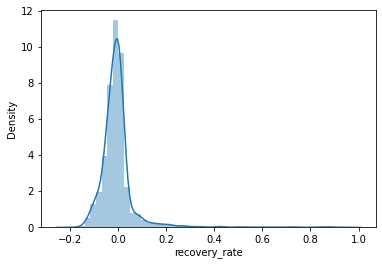

In [65]:
sns.distplot(lgd_targets_stage_2_test - y_test_pred_stage_2)

The residuals look normal validating the assumptions of the linear regression model, hence our interpretation of the coefficients could be taken as pretty good!

## Save the model

In [66]:
import pickle
out_file = os.path.join(PROJECT_DIR, 'outputs', 'lgd_model_stage_2.pkl')
with open(out_file, 'wb') as f:
    pickle.dump(reg_lgd_stage_2, f)

## Combining Stage 1 and Stage 2

### Load Stage 1 model

In [74]:
from src.models import LogisticRegressionWithPValues
fpath = os.path.join(PROJECT_DIR, 'outputs', 'lgd_model_stage_1.pkl')
with open(fpath, 'rb') as f:
    reg_lgd_stage_1 = pickle.load(f)


### Splitting Data (for Stage 1)

In [68]:
DEP_VARS = ['good_bad_loan', 'recovery_rate', 'recovery_rate_0_1', 'ccf']
RANDOM_STATE = 42

In [76]:
from sklearn.model_selection import train_test_split
lgd_inputs_stage_1_train, lgd_inputs_stage_1_test, lgd_targets_stage_1_train, lgd_targets_stage_1_test = train_test_split(loan_data_defaults.drop(DEP_VARS, axis=1), loan_data_defaults['recovery_rate_0_1'],
                                                                                                                         test_size=0.2, random_state=RANDOM_STATE)


lgd_inputs_stage_1_train = lgd_inputs_stage_1_train[variable_lst].drop(variable_ref_cat, axis=1)
lgd_inputs_stage_1_test = lgd_inputs_stage_1_test[variable_lst].drop(variable_ref_cat, axis=1)


In [79]:
pred_prob = reg_lgd_stage_1.predict_proba(lgd_inputs_stage_1_test)[:, 1]
pred_recovery = reg_lgd_stage_2.predict(lgd_inputs_stage_1_test)

In [88]:
pred_lgd = pred_prob*pred_recovery
pd.DataFrame(pred_lgd).rename(columns={0: 'pred_lgd'}).describe()

,pred_lgd
count,"8,648.00000000"
mean,0.06353448
std,0.01707026
min,-0.00405345
25%,0.05281434
50%,0.06391117
75%,0.07500753
max,0.14594903


In [89]:
pred_lgd = np.where(pred_lgd < 0, 0, pred_lgd)
pred_lgd = np.where(pred_lgd > 1, 1, pred_lgd)

In [90]:
pd.DataFrame(pred_lgd).rename(columns={0: 'pred_lgd'}).describe()

,pred_lgd
count,"8,648.00000000"
mean,0.06353553
std,0.01706625
min,0.00000000
25%,0.05281434
50%,0.06391117
75%,0.07500753
max,0.14594903


## EAD Model

### Splitting Data

In [94]:
ead_inputs_train, ead_inputs_test, ead_targets_train, ead_targets_test = train_test_split(loan_data_defaults.drop(DEP_VARS, axis = 1), 
                                                                                          loan_data_defaults['ccf'], test_size = 0.2, random_state = RANDOM_STATE)


ead_inputs_train = ead_inputs_train[variable_lst].drop(variable_ref_cat, axis=1)
ead_inputs_test = ead_inputs_test[variable_lst].drop(variable_ref_cat, axis=1)



In [100]:
ead_inputs_train.dtypes

grade:A                                  uint8
grade:B                                  uint8
grade:C                                  uint8
grade:D                                  uint8
grade:E                                  uint8
grade:F                                  uint8
home_ownership:MORTGAGE                  uint8
home_ownership:NONE                      uint8
home_ownership:OTHER                     uint8
home_ownership:OWN                       uint8
verification_status:Not Verified         uint8
verification_status:Source Verified      uint8
purpose:car                              uint8
purpose:debt_consolidation               uint8
purpose:educational                      uint8
purpose:home_improvement                 uint8
purpose:house                            uint8
purpose:major_purchase                   uint8
purpose:medical                          uint8
purpose:moving                           uint8
purpose:other                            uint8
purpose:renew

### Fit the model

In [102]:
reg_ead = LinearRegressionWithPValues()
reg_ead.fit(ead_inputs_train.astype(float), ead_targets_train.astype(float))

LinearRegressionWithPValues(copy_X=True, fit_intercept=True, n_jobs=None,
                            normalize=False)

In [103]:
smry_table = reg_ead.get_summary_table()
smry_table

,feature_name,coefficient,p_value
0,intercept,1.10975031,nan
1,grade:A,-0.30299201,0.00000000
2,grade:B,-0.23641866,0.00000000
3,grade:C,-0.17201648,0.00000000
4,grade:D,-0.11984122,0.00000000
5,grade:E,-0.06768169,0.00000000
6,grade:F,-0.02045856,0.00442934
7,home_ownership:MORTGAGE,-0.00634108,0.00264149
8,home_ownership:NONE,-0.00553982,0.93188363
9,home_ownership:OTHER,-0.00242839,0.93351801


**Interpretation**:

* Higher CCF implies the exposure at the time when the borrower defaults will be higher.
* The coefficient of **grade:A** is -0.30299201, which means that, as compared to the reference category **grade:G**, the credit conversion factor for someone with **grade:A** is expected to be about 30% lower, which aligns with the intuition that higher the external credit rating, lower the exposure when the person defaults, hence the credit conversion is lower.

### Model Validation

In [105]:
y_test_pred_ead = reg_ead.predict(ead_inputs_test)

In [106]:
np.corrcoef(ead_targets_test, y_test_pred_ead)[0, 1]

0.5306481464386389

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


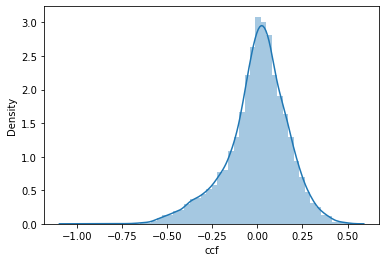

In [107]:
sns.distplot(ead_targets_test - y_test_pred_ead)

In [108]:
y_test_pred_ead = np.where(y_test_pred_ead < 0, 0, y_test_pred_ead)
y_test_pred_ead = np.where(y_test_pred_ead > 1, 1, y_test_pred_ead)

In [111]:
pd.DataFrame(y_test_pred_ead).rename(columns={0: 'pred_ead'}).describe()

,pred_ead
count,"8,648.00000000"
mean,0.73599123
std,0.10512905
min,0.38478059
25%,0.66156434
50%,0.73174691
75%,0.81054563
max,1.00000000


### Save Model

In [112]:
import pickle
out_file = os.path.join(PROJECT_DIR, 'outputs', 'ead_model.pkl')
with open(out_file, 'wb') as f:
    pickle.dump(reg_ead, f)